In [45]:
# ! pip install sklearn
# general imports 
import allensdk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

# set data path
import sys
import platform
import os
from os.path import join as pjoin
from pathlib import Path


import sys
sys.path.insert(0, '/code/src')
import importlib
import plot_utils
# reload it after edits
importlib.reload(plot_utils)
# from data_utils import process_nwb_metadata, get_stim_window, get_spike_counts_all
from plot_utils import create_raster, plot_area_PSTH
# from classifier import get_classifier, run_classifier

In [30]:
platstring = platform.platform()
system = platform.system()
if system == "Darwin":
    # macOS
    data_dir = "/Volumes/Brain2025/"
elif system == "Windows":
    # Windows (replace with the drive letter of USB drive)
    data_dir = "E:/"
elif "amzn" in platstring:
    # then on CodeOcean
    data_dir = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_dir = "/media/$USERNAME/Brain2025/"
data_root = Path(data_dir)
print('data directory set to', data_dir)

data directory set to /data/


In [31]:
# Visual Behavior Neuropixels 
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

cache_dir = '/root/capsule/data/'

cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(
            cache_dir=cache_dir, use_static_cache=True)

In [4]:
behaviour_session_table = cache.get_behavior_session_table() 
ecephys_session_table = cache.get_ecephys_session_table() 
probe_table = cache.get_probe_table() 
channel_table = cache.get_channel_table() 
unit_table = cache.get_unit_table() 

In [5]:
no_genotype_ecephys_session_table = ecephys_session_table[ecephys_session_table.genotype == "wt/wt"]
# no_genotype_ecephys_session_table.head()

In [6]:
CA1_unit_table = unit_table[unit_table.structure_acronym == "CA1"]
# CA1_unit_table.head()

In [9]:
# Let's merge the ecephys_sessions table and units table
CA1_unit_ecephys_table = CA1_unit_table.merge(no_genotype_ecephys_session_table, on='ecephys_session_id')

# Now we have ecephys_sessions and units together
# CA1_unit_ecephys_table.columns
# How many units are CA1? 
print(f"Units in CA1: {len(CA1_unit_ecephys_table)}") 
print(f"stimulus sets: {CA1_unit_ecephys_table.session_type.unique()}")
CA1_unit_ecephys_table.head()

Units in CA1: 11184
stimulus sets: ['EPHYS_1_images_G_3uL_reward' 'EPHYS_1_images_H_3uL_reward'
 'EPHYS_1_images_H_5uL_reward' 'EPHYS_1_images_G_5uL_reward']


,ecephys_channel_id,ecephys_probe_id,ecephys_session_id,amplitude_cutoff,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,cumulative_drift,d_prime,structure_acronym,...,channel_count,structure_acronyms,image_set,prior_exposures_to_image_set,session_number,experience_level,prior_exposures_to_omissions,file_id,abnormal_histology,abnormal_activity
0,1082870721,1081297298,1081079981,9.098659e-07,7796.0,1352.0,7218.0,87.11,11.283012,CA1,...,2304,"['APN', 'CA1', 'DG-mo', 'DG-po', 'DG-sg', 'HPF...",G,23,1,Familiar,0,934,NaN,NaN
1,1082870721,1081297298,1081079981,4.590550e-01,7796.0,1352.0,7218.0,115.00,3.711991,CA1,...,2304,"['APN', 'CA1', 'DG-mo', 'DG-po', 'DG-sg', 'HPF...",G,23,1,Familiar,0,934,NaN,NaN
2,1082870671,1081297298,1081079981,8.260163e-02,7906.0,1587.0,7131.0,200.66,3.467683,CA1,...,2304,"['APN', 'CA1', 'DG-mo', 'DG-po', 'DG-sg', 'HPF...",G,23,1,Familiar,0,934,NaN,NaN
3,1082870671,1081297298,1081079981,5.193935e-02,7906.0,1587.0,7131.0,253.09,3.250599,CA1,...,2304,"['APN', 'CA1', 'DG-mo', 'DG-po', 'DG-sg', 'HPF...",G,23,1,Familiar,0,934,NaN,NaN
4,1082870671,1081297298,1081079981,9.801373e-03,7906.0,1587.0,7131.0,111.52,3.265091,CA1,...,2304,"['APN', 'CA1', 'DG-mo', 'DG-po', 'DG-sg', 'HPF...",G,23,1,Familiar,0,934,NaN,NaN


In [10]:
# Let's merge the ecephys table and behaviour table
behaviour_ecephys_session_table = behaviour_session_table.merge(no_genotype_ecephys_session_table, on='ecephys_session_id')

# Now we have ecephys and behaviour together
behaviour_ecephys_session_table.columns
print(f"stimulus sets: {behaviour_ecephys_session_table.session_type_x.unique()}")

stimulus sets: ['EPHYS_1_images_G_5uL_reward' 'EPHYS_1_images_H_5uL_reward'
 'EPHYS_1_images_H_3uL_reward' 'EPHYS_1_images_G_3uL_reward']


In [11]:
sessions_by_imageset_experience_day = no_genotype_ecephys_session_table.pivot_table(index=['session_number', 'experience_level'], 
                                                                        columns=['image_set'], 
                                                                        values='behavior_session_id', aggfunc=len)
display(sessions_by_imageset_experience_day)

,image_set,G,H
session_number,experience_level,,
1,Familiar,8,10
2,Novel,10,10


In [12]:
#Number of mice per genotype/sex
mice_by_genotype_sex = no_genotype_ecephys_session_table.pivot_table(values='mouse_id', index='genotype', 
                                                          columns='sex', aggfunc=lambda x: len(np.unique(x)))
display(mice_by_genotype_sex)

sex,F,M
genotype,,
wt/wt,8,12


In [13]:
a_novel_session_id = 1044594870
# a_familiar_session_id = 1044385384
a_novel_session = cache.get_ecephys_session(
            ecephys_session_id=a_novel_session_id)
# a_familiar_session = cache.get_ecephys_session(
#             ecephys_session_id=a_familiar_session_id)
a_novel_session.metadata

/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
/opt/conda/lib/python3.9/site-packages/allensdk/brain_observatory/behavior/data_objects/metadata/subject_metadata/full_genotype.py:57: UserWarning: Unable to parse cre_line from full_genotype
  warnings.warn('Unable to parse cre_line from full_genotype')


{'equipment_name': 'NP.1',
 'sex': 'F',
 'age_in_days': 152,
 'stimulus_frame_rate': 60.0,
 'session_type': 'EPHYS_1_images_H_5uL_reward',
 'date_of_acquisition': datetime.datetime(2020, 8, 20, 22, 3, 56, tzinfo=tzutc()),
 'reporter_line': None,
 'cre_line': None,
 'behavior_session_uuid': UUID('3338aa28-9865-443b-a69a-83f78f6dba19'),
 'driver_line': [],
 'mouse_id': '524761',
 'project_code': 'Not Available',
 'full_genotype': 'wt/wt',
 'behavior_session_id': 1044624428,
 'ecephys_session_id': 1044594870}

In [14]:
units = a_novel_session.get_units()
channels = a_novel_session.get_channels()

unit_channels = units.merge(channels, left_on='peak_channel_id', right_index=True)

In [15]:
unit_channels.value_counts('structure_acronym')

structure_acronym
DG       389
CA1      373
VISl     178
CA3      152
VISp     130
VISpm    126
VISal    118
MRN      110
VISrl     89
POL       89
POST      59
LP        56
MGv       45
SCig      36
MB        35
PIL       26
MGd       26
root      19
HPF       15
MGm       14
TH        11
PP         6
SNr        1
dtype: int64

In [16]:
#first let's sort our units by depth
unit_channels = unit_channels.sort_values('probe_vertical_position', ascending=False)

#now we'll filter them
good_unit_filter = ((unit_channels['snr']>1)&
                    (unit_channels['isi_violations']<1)&
                    (unit_channels['firing_rate']>0.1))

good_units = unit_channels.loc[good_unit_filter]
spike_times = a_novel_session.spike_times
stimulus_presentations = a_novel_session.stimulus_presentations
change_times = stimulus_presentations[stimulus_presentations['active']&
                            stimulus_presentations['is_change']]['start_time'].values
stimulus_presentations

,stimulus_block,image_name,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,...,stimulus_index,color,position_x,active,temporal_frequency,contrast,orientation,spatial_frequency,is_sham_change,rewarded
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,,,
0,0,im104_r,0.250213,26.415843,26.666057,60,75,False,True,False,...,-99,NaN,NaN,True,NaN,NaN,NaN,NaN,False,False
1,0,im104_r,0.250213,27.166484,27.416697,105,120,False,True,False,...,-99,NaN,NaN,True,NaN,NaN,NaN,NaN,False,False
2,0,im104_r,0.250199,27.917095,28.167294,150,165,False,True,False,...,-99,NaN,NaN,True,NaN,NaN,NaN,NaN,False,False
3,0,im104_r,0.250216,28.667709,28.917925,195,210,False,True,False,...,-99,NaN,NaN,True,NaN,NaN,NaN,NaN,False,False
4,0,im104_r,0.250199,29.418357,29.668556,240,255,False,True,False,...,-99,NaN,NaN,True,NaN,NaN,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13396,5,im024_r,0.250211,8784.826648,8785.076859,523377,523392,False,True,False,...,-99,NaN,NaN,False,NaN,NaN,NaN,NaN,False,False
13397,5,im024_r,0.250207,8785.577281,8785.827488,523422,523437,False,True,False,...,-99,NaN,NaN,False,NaN,NaN,NaN,NaN,False,False
13398,5,im024_r,0.250206,8786.327901,8786.578107,523467,523482,False,True,False,...,-99,NaN,NaN,False,NaN,NaN,NaN,NaN,False,False


In [86]:
import numpy as np
import matplotlib.pyplot as plt

# reload it after edits
importlib.reload(plot_utils)
from data_utils import process_nwb_metadata, get_stim_window, get_spike_counts_all
from plot_utils import plot_area_psth_and_raster, plot_multi_area_psth_and_raster, build_area_packet

In [77]:
# area_of_interest = 'CA1'
# area_units = good_units[good_units['structure_acronym'] == area_of_interest]
# spike_times_by_unit = [spike_times[iu] for iu, _ in area_units.iterrows()]
# fig, axes, (area_change_responses, bins), order = plot_area_psth_and_raster(
#     area_units_df=area_units,
#     spike_times_by_unit=spike_times_by_unit,
#     event_times=change_times,
#     area_name=area_of_interest,
#     time_before_change=1.0,
#     duration=2.5,
#     bin_size=0.01,
#     raster_unit_idx=0,     # choose which unit to raster
#     sort_key='depth'       # or whatever column you have (e.g., 'probe_vertical_position')
# )


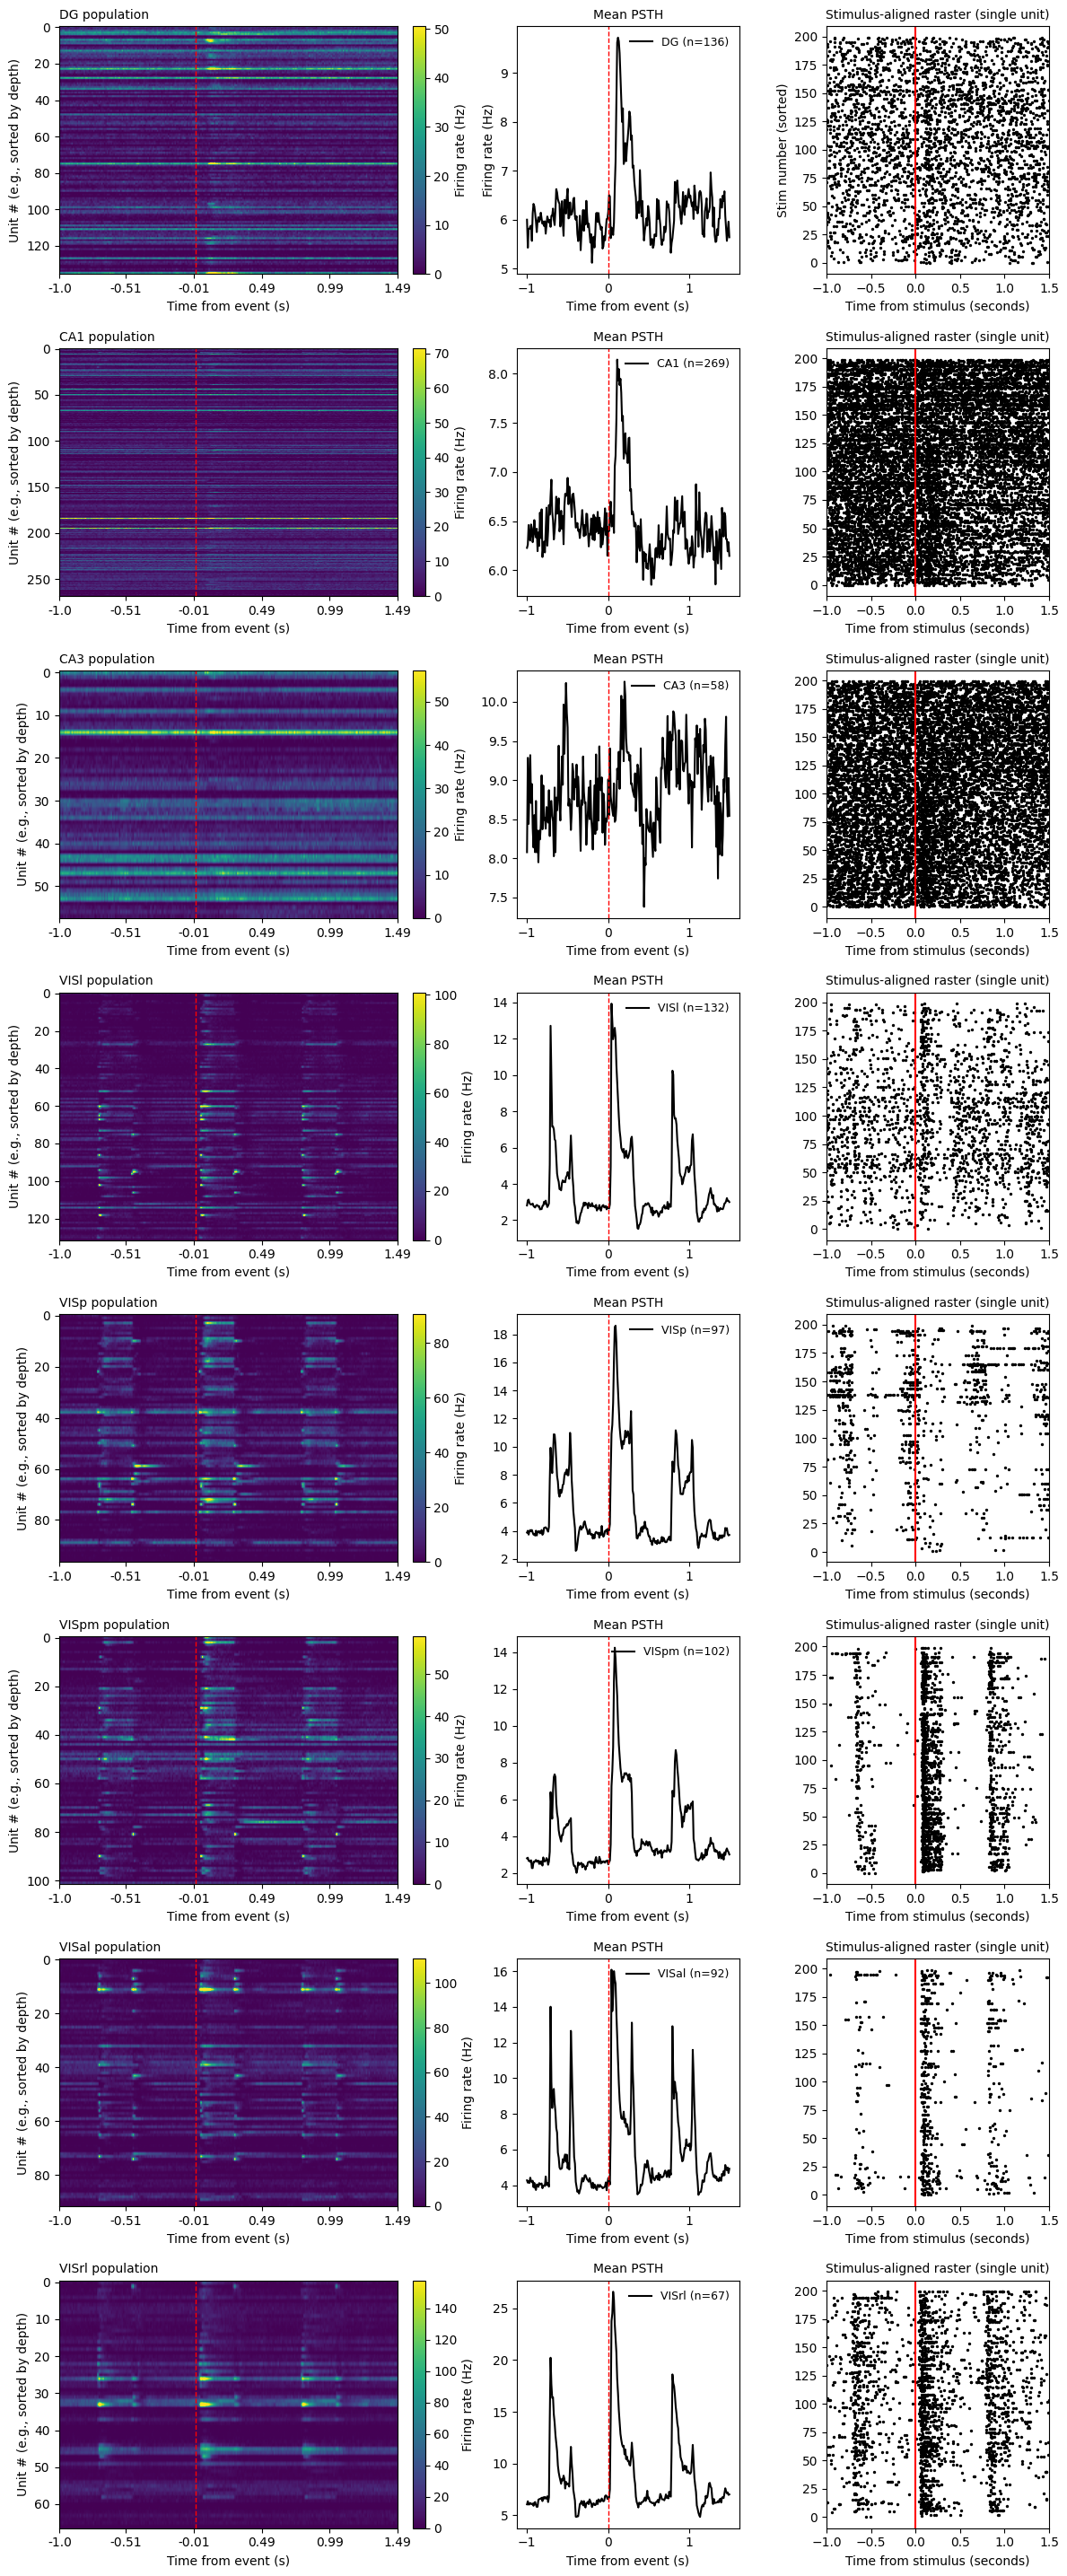

In [87]:
areas_to_plot = ['DG', 'CA1', 'CA3', 'VISl','VISp','VISpm', 'VISal', 'VISrl']
area_packets = [build_area_packet(a, good_units, spike_times, sort_key='depth') 
                for a in areas_to_plot]

fig, axs, results = plot_multi_area_psth_and_raster(area_packets, change_times,
                                                    time_before_change=1.0, duration=2.5, hspace=0.3)


In [70]:
area_unit_metrics = unit_metrics.loc[area_units.index.values]

NameError: name 'unit_metrics' is not defined